In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, njit
from time import perf_counter as time
from functools import lru_cache, cache
import scipy.optimize
import matplotlib.colors as mcolors
from matplotlib import animation
from IPython import display

In [2]:
%matplotlib notebook

In [3]:
np.seterr(divide="raise", invalid="raise", under="raise")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [4]:
@njit
def next_step(airp1, airp2, velo1, velo2, conc1, conc2, source, d):
    Rs = 287.1
    T = 300
    v = 13.3e-3
    for x in range(1, x_size - 1):
        for y in range(1, y_size - 1):
            for z in range(1, z_size - 1):
                border = (x == 1) + (y == 1) + (z == 1) + (x == x_size-2) + (y == y_size-2) + (z == z_size-2)
                
                diff_airp = 0
                
                diff_airp -= airp1[x, y, z] * 0.5/dx * (velo1[x+1, y, z, 0] - velo1[x-1, y, z, 0] + velo1[x, y+1, z, 1] - velo1[x, y-1, z, 1] + velo1[x, y, z+1, 2] - velo1[x, y, z-1, 2])
                diff_airp -= velo1[x, y, z, 0] * 0.5/dx * (airp1[x+1, y, z] - airp1[x-1, y, z])
                diff_airp -= velo1[x, y, z, 1] * 0.5/dx * (airp1[x, y+1, z] - airp1[x, y-1, z])
                diff_airp -= velo1[x, y, z, 2] + 0.5/dx * (airp1[x, y, z+1] - airp1[x, y, z-1])
                
                airp2[x, y, z] = airp1[x, y, z] + dt * diff_airp
                
                diff_velo = np.zeros(3)
                
#                 diff_velo[0] -= dt * velo1[x, y, z,  0] * diff_airp / airp1[x, y, z]
#                 diff_velo[1] -= dt * velo1[x, y, z,  1] * diff_airp / airp1[x, y, z]
#                 diff_velo[2] -= dt * velo1[x, y, z,  2] * diff_airp / airp1[x, y, z]

                diff_velo[0] -= 0.5/dx * (velo1[x, y, z, 0] * (velo1[x+1, y, z, 0] - velo1[x-1, y, z, 0]) + velo1[x, y, z, 1] * (velo1[x, y+1, z, 0] - velo1[x,  y-1, z, 0]) + velo1[x, y, z, 2] * (velo1[x, y, z+1, 0] - velo1[x, y, z-1, 0]))
                diff_velo[1] -= 0.5/dx * (velo1[x, y, z, 0] * (velo1[x+1, y, z, 1] - velo1[x-1, y, z, 1]) + velo1[x, y, z, 1] * (velo1[x, y+1, z, 1] - velo1[x,  y-1, z, 1]) + velo1[x, y, z, 2] * (velo1[x, y, z+1, 1] - velo1[x, y, z-1, 1]))
                diff_velo[2] -= 0.5/dx * (velo1[x, y, z, 0] * (velo1[x+1, y, z, 2] - velo1[x-1, y, z, 2]) + velo1[x, y, z, 1] * (velo1[x, y+1, z, 2] - velo1[x,  y-1, z, 2]) + velo1[x, y, z, 2] * (velo1[x, y, z+1, 2] - velo1[x, y, z-1, 2]))
                
                diff_velo[0] -= Rs*T * 0.5/dx * (airp1[x+1, y, z] - airp1[x-1, y, z]) / airp1[x, y, z]
                diff_velo[1] -= Rs*T * 0.5/dx * (airp1[x, y+1, z] - airp1[x, y-1, z]) / airp1[x, y, z]
                diff_velo[2] -= Rs*T * 0.5/dx * (airp1[x, y, z+1] - airp1[x, y, z-1]) / airp1[x, y, z]
                
#                 diff_velo[0] -= dt/dx * (airp1[x+1, y, z] - airp1[x, y, z]) / airp1[x, y, z]
#                 diff_velo[1] -= dt/dx * (airp1[x, y+1, z] - airp1[x, y, z]) / airp1[x, y, z]
#                 diff_velo[2] -= dt/dx * (airp1[x, y, z+1] - airp1[x, y, z]) / airp1[x, y, z]
        
                diff_velo[0] += v/dx**2 * (velo1[x+1, y, z, 0] + velo1[x-1, y, z, 0] + velo1[x, y+1, z, 0] + velo1[x, y-1, z, 0] + velo1[x, y, z+1, 0] + velo1[x, y, z-1, 0] - 6*velo1[x,  y, z, 0])
                diff_velo[1] += v/dx**2 * (velo1[x+1, y, z, 1] + velo1[x-1, y, z, 1] + velo1[x, y+1, z, 1] + velo1[x, y-1, z, 1] + velo1[x, y, z+1, 1] + velo1[x, y, z-1, 1] - 6*velo1[x,  y, z, 1])
                diff_velo[2] += v/dx**2 * (velo1[x+1, y, z, 2] + velo1[x-1, y, z, 2] + velo1[x, y+1, z, 2] + velo1[x, y-1, z, 2] + velo1[x, y, z+1, 2] + velo1[x, y, z-1, 2] - 6*velo1[x,  y, z, 2])

                diff_velo[0] += 1/3*v/dx**2 * (velo1[x+1, y, z, 0] + velo1[x-1, y, z, 0] - 2*velo1[x, y, z, 0])
                diff_velo[0] += 1/3*v/dx**2 * 1/4 * (velo1[x+1, y+1, z, 1] + velo1[x-1, y-1, z, 1] - velo1[x+1, y-1, z, 1] - velo1[x-1, y+1, z, 1] + velo1[x+1, y, z+1, 2] + velo1[x-1, y, z-1, 2] - velo1[x+1, y, z-1, 2] - velo1[x-1, y, z+1, 2])
                
                diff_velo[1] += 1/3*v/dx**2 * (velo1[x, y+1, z, 1] + velo1[x, y-1, z, 1] - 2*velo1[x, y, z, 1])
                diff_velo[1] += 1/3*v/dx**2 * 1/4 * (velo1[x+1, y+1, z, 0] + velo1[x-1, y-1, z, 0] - velo1[x+1, y-1, z, 0] - velo1[x-1, y+1, z, 0] + velo1[x, y+1, z+1, 2] + velo1[x, y-1, z-1, 2] - velo1[x, y+1, z-1, 2] - velo1[x, y-1, z+1, 2])
                
                diff_velo[2] += 1/3*v/dx**2 * (velo1[x, y, z+1, 2] + velo1[x, y, z-1, 2] - 2*velo1[x, y, z, 2])
                diff_velo[2] += 1/3*v/dx**2 * 1/4 * (velo1[x+1, y, z+1, 0] + velo1[x-1, y, z-1, 0] - velo1[x+1, y, z-1, 0] - velo1[x-1, y, z+1, 0] + velo1[x, y+1, z+1, 1] + velo1[x, y-1, z-1, 1] - velo1[x, y+1, z-1, 1] - velo1[x, y-1, z+1, 1])
                
#                 diff_velo[2] -= 9.81 #m/s^2
                
                velo2[x, y, z] = velo1[x, y, z] + dt * diff_velo
        
#                 if x == 1 and velo2[x, y, z, 0] < 0:
#                     velo2[x, y, z, 0] = 0
#                 if y == 1 and velo2[x, y, z, 1] < 0:
#                     velo2[x, y, z, 1] = 0
#                 if z == 1 and velo2[x, y, z, 2] < 0:
#                     velo2[x, y, z, 2] = 0
                    
#                 if x == x_size - 2 and velo2[x, y, z, 0] > 0:
#                     velo2[x, y, z, 0] = 0
#                 if y == y_size - 2 and velo2[x, y, z, 1] > 0:
#                     velo2[x, y, z, 1] = 0
#                 if z == z_size - 2 and velo2[x, y, z, 2] > 0:
#                     velo2[x, y, z, 2] = 0
                
                
                
#                 if x == 12 and y == 14 and z == 11:
#                     velo2[x, y, z, 2] = 0.1
                    
#                 conc2[x, y, z] += (d*dt/(dx**2)) * (conc1[x-1, y, z] + conc1[x+1, y, z] + conc1[x, y-1, z] + conc1[x, y+1, z] + conc1[x, y, z-1] + conc1[x, y, z+1] - (6 - border) * conc1[x, y, z])
                
#                 if x == 12 and y == 14 and z == 11:
#                     conc2[x, y, z] += source*dt

In [5]:
def next_frame(i, ax, airp1, airp2, velo1, velo2, conc1, conc2, source, d):
    if(i%100 == 0):
        print(i//100, time())
    t = (i+1)*dt
    if i%2:
        next_step(airp2, airp1, velo2, velo1, conc2, conc1, source, d)
    
#         offset = mcolors.TwoSlopeNorm(vcenter=0.0)
#         img = ax.imshow(velo1[16, :, :, 0].T, cmap="bwr", norm=offset, origin="lower")

        offset = mcolors.TwoSlopeNorm(vcenter=1.2041)
        img = ax.imshow(airp1[16, :, :].T, cmap="bwr", norm=offset, origin="lower")
        text = ax.text(21.5, 20, f"t = {t:.5f} s", backgroundcolor="white")
        text_max = ax.text(21.5, 15, f"max_v = {np.abs(velo1[16, :, :, 0]).max():.3f} m/s", backgroundcolor="white")
#         cb = fig.colorbar(img, ax=ax)
        
        return img, text, text_max
    
    else:
        next_step(airp1, airp2, velo1, velo2, conc1, conc2, source, d)
    
#         offset = mcolors.TwoSlopeNorm(vcenter=0.0)
#         img = ax.imshow(velo2[16, :, :, 0].T, cmap="bwr", norm=offset, origin="lower")

        offset = mcolors.TwoSlopeNorm(vcenter=1.2041)
        img = ax.imshow(airp2[16, :, :].T, cmap="bwr", norm=offset, origin="lower")
        text = ax.text(21.5, 20, f"t = {t:.5f} s", backgroundcolor="white")
        text_max = ax.text(21.5, 15, f"max_v = {np.abs(velo2[16, :, :, 0]).max():.3f} m/s", backgroundcolor="white")
#         cb = fig.colorbar(img, ax=ax)
        
        return img, text, text_max

In [6]:
# setup ------------------------------------------
x_size = 36 + 2
y_size = 19 + 2
z_size = 25 + 2
dx = 0.1 #m
dt = 0.00001 #s
# time_steps = (int((60*60) // dt / 2) + 1) * 2
time_steps = 50000
print(time_steps)

d = 0.01

source = 400.0 / dx**3 / 60

conc1 = np.zeros((x_size, y_size, z_size))
conc2 = np.zeros((x_size, y_size, z_size))

airp1 = np.ones((x_size, y_size, z_size)) * 1.2041
airp2 = np.ones((x_size, y_size, z_size)) * 1.2041

# airp1[0, :, :] *= 0
# airp1[:, 0, :] *= 0
# airp1[:, :, 0] *= 0
# airp1[-1, :, :] *= 0
# airp1[:, -1, :] *= 0
# airp1[:, :, -1] *= 0

# airp2[0, :, :] *= 0
# airp2[:, 0, :] *= 0
# airp2[:, :, 0] *= 0
# airp2[-1, :, :] *= 0
# airp2[:, -1, :] *= 0
# airp2[:, :, -1] *= 0

velo1 = np.zeros((x_size, y_size, z_size, 3))
velo2 = np.zeros((x_size, y_size, z_size, 3))

sensor = np.zeros((time_steps))
sensor_v = np.zeros((time_steps))

# velo1[16, 10, 12, 0] = 0.1
velo1[16, 10, 12, 2] = 0.1

50000


<IPython.core.display.Javascript object>


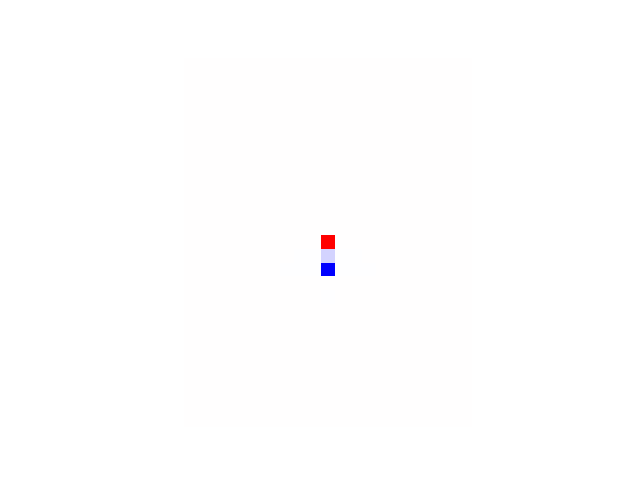

In [7]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)

ax.text(21, 0, f"dt = {dt}\nGeschwindigkeit an\neinem Ort\n0,1m/s in z-Richtung")

ax.set_title("Luftdichte")
ax.set_xlabel("y")
ax.set_ylabel("z")


anim = animation.FuncAnimation(fig, next_frame, frames=int(400), interval=1000//30, blit=True, fargs=(ax, airp1, airp2, velo1, velo2, conc1, conc2, source, d))

plt.show()
# print("start converting")
# video = anim.to_html5_video()
# print("finished converting")
# html = display.HTML(video)
# display.display(html)
# plt.close()